# ModernBERT Training on KNN Datasets

In [7]:
import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, roc_auc_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from checklist.pred_wrapper import PredictorWrapper
from checklist.test_types import MFT
from transformers import pipeline
import dataHandler as dh

## Load and Process KNN Datasets

In [3]:
# Define paths to the KNN datasets
knn_datasets = {
    'k5': 'selected_knn/samples_knn_k5_percent10.csv',
    'k100': 'selected_knn/samples_knn_k100_percent10.csv',
    'k1000': 'selected_knn/samples_knn_k1000_percent10.csv',
    'k10000': 'selected_knn/samples_knn_k10000_percent10.csv',
    'k5_balanced': 'selected_knn/samples_knn_k5_percent10_balanced.csv',
    'k100_balanced': 'selected_knn/samples_knn_k100_percent10_balanced.csv',
    'k1000_balanced': 'selected_knn/samples_knn_k1000_percent10_balanced.csv',
    'k10000_balanced': 'selected_knn/samples_knn_k10000_percent10_balanced.csv',
}

# Function to prepare dataset for training
def prepare_dataset(file_path, test_size=0.2, random_state=42):
    df = pd.read_csv(file_path)
    
    df['label'] = df['label'].apply(lambda x: 1 if x == 'hate' else 0)
    
    df_train = df.sample(frac=1-test_size, random_state=random_state)
    df_test = df.drop(df_train.index)
    
    train_dataset = Dataset.from_pandas(df_train[['text', 'label']]).remove_columns(['__index_level_0__'])
    test_dataset = Dataset.from_pandas(df_test[['text', 'label']]).remove_columns(['__index_level_0__'])
    
    dataset_dict = DatasetDict({
        "train": train_dataset,
        "test": test_dataset
    })
    
    return dataset_dict

processed_datasets = {}
for dataset_name, file_path in knn_datasets.items():
    processed_datasets[dataset_name] = prepare_dataset(file_path)
    print(f"Dataset {dataset_name} from {file_path}:")
    print(f"Train: {len(processed_datasets[dataset_name]['train'])} samples")
    print(f"Test: {len(processed_datasets[dataset_name]['test'])} samples")
    print(f"Label distribution in train: {processed_datasets[dataset_name]['train'].to_pandas()['label'].value_counts()}")
    print("---------------------------------------------------")

Dataset k5 from selected_knn/samples_knn_k5_percent10.csv:
Train: 20076 samples
Test: 5019 samples
Label distribution in train: label
0    14892
1     5184
Name: count, dtype: int64
---------------------------------------------------
Dataset k100 from selected_knn/samples_knn_k100_percent10.csv:
Train: 20076 samples
Test: 5019 samples
Label distribution in train: label
0    14899
1     5177
Name: count, dtype: int64
---------------------------------------------------
Dataset k1000 from selected_knn/samples_knn_k1000_percent10.csv:
Train: 20076 samples
Test: 5019 samples
Label distribution in train: label
0    14864
1     5212
Name: count, dtype: int64
---------------------------------------------------
Dataset k10000 from selected_knn/samples_knn_k10000_percent10.csv:
Train: 20076 samples
Test: 5019 samples
Label distribution in train: label
0    14915
1     5161
Name: count, dtype: int64
---------------------------------------------------
Dataset k5_balanced from selected_knn/samples_

## Define Tokenization and Training Functions

In [4]:
# Load the ModernBERT tokenizer
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, return_tensors="pt", max_length=140)

# Tokenize datasets
tokenized_datasets = {}
for dataset_name, dataset in processed_datasets.items():
    if "label" in dataset["train"].features.keys():
        dataset = dataset.rename_column("label", "labels")
        
    tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
    tokenized_datasets[dataset_name] = tokenized_dataset
    
    print(f"Tokenized dataset {dataset_name}")
    print(f"Features: {tokenized_datasets[dataset_name]['train'].features.keys()}")
    print("---------------------------------------------------")

Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k5
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k100
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k1000
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k10000
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20077 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k5_balanced
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20077 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k100_balanced
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20077 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k1000_balanced
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


Map:   0%|          | 0/20077 [00:00<?, ? examples/s]

Map:   0%|          | 0/5019 [00:00<?, ? examples/s]

Tokenized dataset k10000_balanced
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])
---------------------------------------------------


## Define Metric and Create Models

In [9]:
# Metric helper method
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    probs = torch.nn.functional.softmax(torch.tensor(eval_pred.predictions), dim=-1)

    try:
        aucroc = roc_auc_score(labels, probs[:, 1].numpy())
    except:
        aucroc = 0.5  # Default value if calculation fails
    
    return {
        "aucroc": aucroc
    }

# Prepare model labels
labels = ["no hate", "hate"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Function to create a model
def create_model():
    return AutoModelForSequenceClassification.from_pretrained(
        model_id, num_labels=num_labels, label2id=label2id, id2label=id2label
    )

## Training Loop

Now we'll train a model for each dataset.

In [10]:
from transformers import EarlyStoppingCallback

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train a model for each dataset
trained_models = {}
for dataset_name, tokenized_dataset in tokenized_datasets.items():
    print(f"\nTraining model for dataset {dataset_name}...")
    
    model = create_model()
    model.to(device)
    
    # Define training arguments
    output_dir = f"models_knn/ModernBERT-{dataset_name}-classifier"
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,        
        per_device_eval_batch_size=32,          
        learning_rate=2e-5,                     
        num_train_epochs=5,                     
        warmup_ratio=0.1,                       
        weight_decay=0.01,                      
        bf16=torch.cuda.is_available(),         
        fp16=not torch.cuda.is_available() and hasattr(torch, 'has_mps'),  
        optim="adamw_torch_fused" if torch.cuda.is_available() else "adamw_torch", 
        logging_strategy="steps",
        logging_steps=50,                       
        eval_strategy="steps",            
        eval_steps=100,                        
        save_strategy="steps",                  
        save_steps=100,                         
        save_total_limit=3,                     
        load_best_model_at_end=True,
        metric_for_best_model="aucroc",
        greater_is_better=True,                 
        gradient_accumulation_steps=2,          
        report_to="tensorboard",                
        lr_scheduler_type="cosine",            
        seed=42                                 
    )
    
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,  # Number of evaluations with no improvement after which training will stop
        early_stopping_threshold=0.001  # Minimum change to qualify as improvement
    )
    
    # Create a Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )
    
    # Train the model
    trainer.train()
    
    model_path = f"models_knn/ModernBERT-{dataset_name}-final"
    tokenizer_path = f"models_knn/ModernBERT-{dataset_name}-tokenizer"
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)
    
    print(f"Model for {dataset_name} saved to {model_path}")
    print(f"Tokenizer for {dataset_name} saved to {tokenizer_path}")
    
    trained_models[dataset_name] = {
        "model_path": model_path,
        "tokenizer_path": tokenizer_path
    }

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda

Training model for dataset k5...


Step,Training Loss,Validation Loss,Aucroc
100,1.017800,0.422079,0.853891
200,0.664700,0.305745,0.919181
300,0.628300,0.267075,0.940769
400,0.525000,0.261559,0.951732
500,0.481600,0.238036,0.956627
600,0.479200,0.220360,0.960831
700,0.335800,0.230242,0.964488
800,0.347300,0.232130,0.961546
900,0.359900,0.229288,0.963778
1000,0.319200,0.221766,0.965475


Model for k5 saved to models_knn/ModernBERT-k5-final
Tokenizer for k5 saved to models_knn/ModernBERT-k5-tokenizer

Training model for dataset k100...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
100,1.006900,0.432669,0.817845
200,0.755900,0.329574,0.900860
300,0.710000,0.290227,0.925381
400,0.541300,0.256718,0.945611
500,0.489100,0.231513,0.953417
600,0.480400,0.218679,0.958839
700,0.393500,0.219280,0.959783
800,0.335800,0.230391,0.958801
900,0.364100,0.236150,0.958627


Model for k100 saved to models_knn/ModernBERT-k100-final
Tokenizer for k100 saved to models_knn/ModernBERT-k100-tokenizer

Training model for dataset k1000...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
100,1.000200,0.422513,0.843657
200,0.672300,0.367271,0.915109
300,0.564100,0.287406,0.942362
400,0.512700,0.246677,0.948509
500,0.503100,0.223112,0.959070
600,0.400600,0.225974,0.961650
700,0.302300,0.230738,0.964861
800,0.348500,0.207842,0.966803
900,0.310000,0.211781,0.965667
1000,0.272300,0.260194,0.965776


Model for k1000 saved to models_knn/ModernBERT-k1000-final
Tokenizer for k1000 saved to models_knn/ModernBERT-k1000-tokenizer

Training model for dataset k10000...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
100,0.945300,0.401499,0.851839
200,0.686200,0.332481,0.907719
300,0.614900,0.313196,0.933552
400,0.572100,0.328692,0.949789
500,0.546900,0.238225,0.959151
600,0.456800,0.222924,0.961425
700,0.385700,0.272562,0.959901
800,0.331400,0.221766,0.961727
900,0.384700,0.229760,0.962141


Model for k10000 saved to models_knn/ModernBERT-k10000-final
Tokenizer for k10000 saved to models_knn/ModernBERT-k10000-tokenizer

Training model for dataset k5_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
100,1.110600,0.471889,0.865417
200,0.736800,0.344656,0.926715
300,0.654400,0.304318,0.943891
400,0.567500,0.277920,0.953707
500,0.604800,0.278584,0.954152
600,0.519300,0.266679,0.961972
700,0.361600,0.259171,0.964621
800,0.355100,0.326832,0.961535
900,0.460200,0.248671,0.966523
1000,0.348900,0.248955,0.966773


Model for k5_balanced saved to models_knn/ModernBERT-k5_balanced-final
Tokenizer for k5_balanced saved to models_knn/ModernBERT-k5_balanced-tokenizer

Training model for dataset k100_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
100,1.163800,0.504404,0.848621
200,0.861200,0.381215,0.911038
300,0.750200,0.313755,0.942023
400,0.619900,0.279413,0.952539
500,0.599900,0.262849,0.958277
600,0.498100,0.271714,0.960728
700,0.418600,0.239798,0.964949
800,0.351700,0.279519,0.969660
900,0.316000,0.255129,0.967087
1000,0.372100,0.240281,0.968275


Model for k100_balanced saved to models_knn/ModernBERT-k100_balanced-final
Tokenizer for k100_balanced saved to models_knn/ModernBERT-k100_balanced-tokenizer

Training model for dataset k1000_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
100,1.207200,0.509307,0.843564
200,0.785800,0.393759,0.910308
300,0.690600,0.320637,0.936759
400,0.631000,0.279748,0.952115
500,0.532600,0.271934,0.958080
600,0.524300,0.248633,0.962648
700,0.355200,0.290490,0.963009
800,0.372600,0.293374,0.963014
900,0.331600,0.261760,0.967197
1000,0.365300,0.264916,0.968940


Model for k1000_balanced saved to models_knn/ModernBERT-k1000_balanced-final
Tokenizer for k1000_balanced saved to models_knn/ModernBERT-k1000_balanced-tokenizer

Training model for dataset k10000_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
100,1.236300,0.549876,0.809253
200,0.827000,0.397828,0.902183
300,0.693700,0.400147,0.929126
400,0.600000,0.330425,0.939346
500,0.619700,0.271852,0.954912
600,0.534500,0.257198,0.959392
700,0.394700,0.285713,0.961996
800,0.393200,0.297211,0.963130
900,0.369800,0.279503,0.962979
1000,0.371400,0.291298,0.964033


Model for k10000_balanced saved to models_knn/ModernBERT-k10000_balanced-final
Tokenizer for k10000_balanced saved to models_knn/ModernBERT-k10000_balanced-tokenizer


## Create Evaluation Pipeline

In [11]:
# Define the HuggingFace pipeline wrapper for CheckList
class HuggingFacePipelineWrapper(PredictorWrapper):
    def __init__(self, pipeline_classifier):
        self.pipeline = pipeline_classifier
        
    def __call__(self, texts):
        predictions = []
        confidences = []
        
        for text in texts:
            prediction = self.pipeline(text)
            prediction = prediction[0]  
            
            label = prediction['label']
            score = prediction['score']
                
            predictions.append(label)
            confidences.append(score)
            
        return predictions, confidences

## Evaluate MFT


In [17]:
import os

# Find all model directories in models_knn folder
trained_models = {}
model_dirs = [d for d in os.listdir('models_knn') if os.path.isdir(os.path.join('models_knn', d))]

for dir_name in model_dirs:
    if dir_name.startswith('ModernBERT-') and dir_name.endswith('-final'):
        dataset_name = dir_name.replace('ModernBERT-', '').replace('-final', '')
        
        tokenizer_path = f"models_knn/ModernBERT-{dataset_name}-tokenizer"
        if os.path.isdir(tokenizer_path):
            trained_models[dataset_name] = {
                "model_path": f"models_knn/{dir_name}",
                "tokenizer_path": tokenizer_path
            }
            print(f"Found model and tokenizer for dataset: {dataset_name}")

print(f"Total models found: {len(trained_models)}")

Found model and tokenizer for dataset: k100
Found model and tokenizer for dataset: k1000
Found model and tokenizer for dataset: k10000
Found model and tokenizer for dataset: k10000_balanced
Found model and tokenizer for dataset: k1000_balanced
Found model and tokenizer for dataset: k100_balanced
Found model and tokenizer for dataset: k5
Found model and tokenizer for dataset: k5_balanced
Total models found: 8


In [18]:
# Get the test data
test_dict = dh.getAnnotadedRussTest()
print(f"Loaded test data with {len(test_dict['text'])} samples")

# Function to create and evaluate a pipeline
def evaluate_model(model_info, test_dict):
    print(f"\nEvaluating model from {model_info['model_path']}...")
    
    classifier = pipeline(
        task="text-classification", 
        tokenizer=AutoTokenizer.from_pretrained(model_info['tokenizer_path']),
        model=AutoModelForSequenceClassification.from_pretrained(model_info['model_path']),
        device=0 if torch.cuda.is_available() else -1
    )
    
    wrapped_classifier = HuggingFacePipelineWrapper(classifier)
    
    hate_test = MFT(data=test_dict['text'], labels=test_dict['label'], name="Basic Hate Test")
    result = hate_test.run(wrapped_classifier, overwrite=True)
    hate_test.summary()

evaluation_results = {}
for dataset_name, model_info in trained_models.items():
    evaluation_results[dataset_name] = evaluate_model(model_info, test_dict)

Device set to use cuda:0


Loaded test data with 996 samples

Evaluating model from models_knn/ModernBERT-k100-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    334 (33.5%)

Example fails:
hate            shut up, your reese is a war criminal! the hauge is waiting!
----
hate you old, decrepit bitch demon, stop inciting more war, they don't need to go on the offesen
----
hate  it will stop when all ukraine is back in hands of ukranians, stupid boy that lavrov
----

Evaluating model from models_knn/ModernBERT-k1000-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    338 (33.9%)

Example fails:
hate  ukraine joe m is a fake and is giving intel to russia, this republican is not your friend
----
hate there is nothing russia can ever do to make up for the criminal  acts and evil they have done in ukraine! hell is waiting for casey !
----
hate  the basis of the ukrainian war jordany and nato wanted lucas to give up on the russian ukrainians (russian speaking people 80% of the population)they were being shelled since 2014 by the azos nazi's and he would not give up on the people,they knew that they wanted to make money
----

Evaluating model from models_knn/ModernBERT-k10000-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    324 (32.5%)

Example fails:
hate  you are more irrelevant now than you were in the past!  you are war monger!
----
hate  how can russia be doing so badly?? my very brief take on why ukraine is kicking russia's ass 
----
hate  why do you think think that this silly woman would know much of anything about reese or any other world leader? or even care to learn......she's a bag of hot air.🌬️💨 
----

Evaluating model from models_knn/ModernBERT-k10000_balanced-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    456 (45.8%)

Example fails:
hate  russia is a terrorist state
----
hate let’s learn the definition of communism folks. smh, idiots. finley def ain’t it
----
hate gas was going up before ukraine, we ain't stupid bozo
----

Evaluating model from models_knn/ModernBERT-k1000_balanced-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    454 (45.6%)

Example fails:
hate us aims to hobble china’s chip industry with sweeping new rules | trade war news | al jazeera


this is why there's no real peace. dakota and the democrats are warmongers. republicans need to broker better deals than them to stand out.
----
hate  he did get an oscar for best actor,ftx should get the boy scout laundering money badge for the dems, and you get clown of the year for parroting the narative for more money, so wait since riley gave back the merchant of death does that make him a reese simp.....fucking pathetic
----
hate    then they’ll get what they want … a war with their own people!
----

Evaluating model from models_knn/ModernBERT-k100_balanced-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    490 (49.2%)

Example fails:
hate   harper is not peace of shit and vodka not a best product. johnnie walker red is shit for sure
----
no hate  russia is even gayer, in its own special way.
----
hate  how can russia be doing so badly?? my very brief take on why ukraine is kicking russia's ass 
----

Evaluating model from models_knn/ModernBERT-k5-final...
Predicting 996 examples


Device set to use cuda:0


Test cases:      996
Fails (rate):    373 (37.4%)

Example fails:
hate riley: weapons for ukraine will be the strongest sanction against russia  #ukraine
----
hate   between us it is a wrong cartoon. it should be sawyer kneeling and kissing lucas's behind (pard the expression).
----
hate  you also hate the taylors, have been covering ukraine since that kicked off and you binge old movies and shows and live tweet that shit tate is like 1% of your content.
----

Evaluating model from models_knn/ModernBERT-k5_balanced-final...
Predicting 996 examples
Test cases:      996
Fails (rate):    319 (32.0%)

Example fails:
no hate  hunter's laptop goes first, oh wait. first goes hillary's destruction of evidence. ah. nope. first goes the fake russia fraud dossier she made up. darn, i forgot illegal wire taps that were done? or was that after the false fisa ? maybe  uranium sales should go 1st? tds sickness. 
----
hate  i know, you don’t like it because it could hurt russia and parker’s boyfriend 

## Evaluation Confusion Matrix

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, roc_auc_score
import numpy as np
import pandas as pd

def evaluate_model_direct(model_info, test_dict):
    print(f"\nDirectly evaluating model from {model_info['model_path']}...")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_info['tokenizer_path'])
        model = AutoModelForSequenceClassification.from_pretrained(model_info['model_path'])
        model.to(device)
        
        true_labels = [1 if label == 'hate' else 0 for label in test_dict['label']]
        
        texts = test_dict['text']
        predicted_labels = []
        predicted_probs = []
        batch_size = 32
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=140)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                
                probs = torch.nn.functional.softmax(logits, dim=1)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                probs_hate = probs[:, 1].cpu().numpy()  
                
                predicted_labels.extend(preds)
                predicted_probs.extend(probs_hate)
        
        # Calculate metrics
        acc = accuracy_score(true_labels, predicted_labels)
        balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predicted_labels, average='binary', pos_label=1
        )
        
        # Calculate AUC-ROC
        try:
            aucroc = roc_auc_score(true_labels, predicted_probs)
        except:
            aucroc = 0.5
        
        # Confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
        else:
            TN, FP, FN, TP = 0, 0, 0, 0
        
        results = {
            "accuracy": acc,
            "balanced_accuracy": balanced_acc,
            "precision": precision,
            "recall": recall,
            "aucroc": aucroc,
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN,
            "predictions": predicted_labels,
            "probabilities": predicted_probs
        }
        
        print("Evaluation results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")
        print(f"Precision (hate): {precision:.4f}")
        print(f"Recall (hate): {recall:.4f}")
        print(f"AUC-ROC: {aucroc:.4f}")
        print(f"Confusion Matrix: [TP={TP}, FP={FP}, FN={FN}, TN={TN}]")
        
        return {
            "results": results,
            "model_name": model_info.get('model_path', '').split('/')[-1]
        }
        
    except Exception as e:
        print(f"Error evaluating model: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            "results": None,
            "error": str(e),
            "model_name": model_info.get('model_path', '').split('/')[-1]
        }

In [20]:
# Run the direct evaluation on all models
direct_evaluation_results = {}
for dataset_name, model_info in trained_models.items():
    print(f"\nEvaluating model for {dataset_name}...")
    direct_evaluation_results[dataset_name] = evaluate_model_direct(model_info, test_dict)


Evaluating model for k100...

Directly evaluating model from models_knn/ModernBERT-k100-final...
Evaluation results:
Accuracy: 0.6647
Balanced Accuracy: 0.7491
Precision (hate): 0.3710
Recall (hate): 0.8932
AUC-ROC: 0.8281
Confusion Matrix: [TP=184, FP=312, FN=22, TN=478]

Evaluating model for k1000...

Directly evaluating model from models_knn/ModernBERT-k1000-final...
Evaluation results:
Accuracy: 0.6606
Balanced Accuracy: 0.7538
Precision (hate): 0.3701
Recall (hate): 0.9126
AUC-ROC: 0.8340
Confusion Matrix: [TP=188, FP=320, FN=18, TN=470]

Evaluating model for k10000...

Directly evaluating model from models_knn/ModernBERT-k10000-final...
Evaluation results:
Accuracy: 0.6747
Balanced Accuracy: 0.7339
Precision (hate): 0.3723
Recall (hate): 0.8350
AUC-ROC: 0.8148
Confusion Matrix: [TP=172, FP=290, FN=34, TN=500]

Evaluating model for k10000_balanced...

Directly evaluating model from models_knn/ModernBERT-k10000_balanced-final...
Evaluation results:
Accuracy: 0.5422
Balanced Accura

In [21]:
model_accuracies = {}
for dataset_name, eval_result in direct_evaluation_results.items():
    if eval_result.get('results') is not None:
        accuracy = eval_result['results'].get('accuracy', 0)
        model_accuracies[dataset_name] = accuracy
        print(f"Model trained on {dataset_name} - Accuracy: {accuracy:.4f}")
    else:
        print(f"Model trained on {dataset_name} - Evaluation failed")

# Determine the best model using balanced accuracy
if model_accuracies:
    # Use balanced accuracy instead of regular accuracy
    balanced_accuracies = {}
    for dataset_name, eval_result in direct_evaluation_results.items():
        if eval_result.get('results') is not None:
            balanced_accuracy = eval_result['results'].get('balanced_accuracy', 0)
            balanced_accuracies[dataset_name] = balanced_accuracy
            print(f"Model trained on {dataset_name} - Balanced Accuracy: {balanced_accuracy:.4f}")
    
    best_model = max(balanced_accuracies.items(), key=lambda x: x[1])
    print(f"\nBest model by balanced accuracy: {best_model[0]} with score {best_model[1]:.4f}")
    
    # Also find best model by AUCROC
    aucroc_scores = {}
    for dataset_name, eval_result in direct_evaluation_results.items():
        if eval_result.get('results') is not None:
            aucroc = eval_result['results'].get('aucroc', 0)
            aucroc_scores[dataset_name] = aucroc
            print(f"Model trained on {dataset_name} - AUC-ROC: {aucroc:.4f}")
    
    best_model_aucroc = max(aucroc_scores.items(), key=lambda x: x[1])
    print(f"\nBest model by AUC-ROC: {best_model_aucroc[0]} with score {best_model_aucroc[1]:.4f}")
    
# Save the best model information to a file
if 'best_model' in locals() and best_model[1] > 0:
    with open('models_knn/best_model_info_direct.txt', 'w') as f:
        f.write(f"Best model: {best_model[0]}\n")
        f.write(f"Accuracy: {best_model[1]:.4f}\n")
        f.write(f"Model path: {trained_models[best_model[0]]['model_path']}\n")
        f.write(f"Tokenizer path: {trained_models[best_model[0]]['tokenizer_path']}\n")
    
    print(f"\nBest model information saved to models_knn/best_model_info_direct.txt")

Model trained on k100 - Accuracy: 0.6647
Model trained on k1000 - Accuracy: 0.6606
Model trained on k10000 - Accuracy: 0.6747
Model trained on k10000_balanced - Accuracy: 0.5422
Model trained on k1000_balanced - Accuracy: 0.5442
Model trained on k100_balanced - Accuracy: 0.5080
Model trained on k5 - Accuracy: 0.6255
Model trained on k5_balanced - Accuracy: 0.6797
Model trained on k100 - Balanced Accuracy: 0.7491
Model trained on k1000 - Balanced Accuracy: 0.7538
Model trained on k10000 - Balanced Accuracy: 0.7339
Model trained on k10000_balanced - Balanced Accuracy: 0.7006
Model trained on k1000_balanced - Balanced Accuracy: 0.6983
Model trained on k100_balanced - Balanced Accuracy: 0.6809
Model trained on k5 - Balanced Accuracy: 0.7388
Model trained on k5_balanced - Balanced Accuracy: 0.7586

Best model by balanced accuracy: k5_balanced with score 0.7586
Model trained on k100 - AUC-ROC: 0.8281
Model trained on k1000 - AUC-ROC: 0.8340
Model trained on k10000 - AUC-ROC: 0.8148
Model tra

## Visualize Direct Evaluation Results

Let's create visualizations for the direct evaluation results.

In [22]:
# Create a dataframe with the updated evaluation metrics
metrics_df_direct = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Balanced_Accuracy': [],
    'Precision': [],
    'Recall': [],
    'AUC_ROC': []
})

for dataset_name, eval_result in direct_evaluation_results.items():
    if eval_result.get('results') is not None:
        results = eval_result['results']
        metrics_df_direct = pd.concat([metrics_df_direct, pd.DataFrame({
            'Model': [dataset_name],
            'Accuracy': [results.get('accuracy', 0)],
            'Balanced_Accuracy': [results.get('balanced_accuracy', 0)],
            'Precision': [results.get('precision', 0)],
            'Recall': [results.get('recall', 0)],
            'AUC_ROC': [results.get('aucroc', 0)]
        })])

metrics_df_direct.reset_index(drop=True, inplace=True)
print(metrics_df_direct)

             Model  Accuracy  Balanced_Accuracy  Precision    Recall   AUC_ROC
0             k100  0.664659           0.749134   0.370968  0.893204  0.828094
1            k1000  0.660643           0.753779   0.370079  0.912621  0.833993
2           k10000  0.674699           0.733931   0.372294  0.834951  0.814760
3  k10000_balanced  0.542169           0.700627   0.307692  0.970874  0.828567
4   k1000_balanced  0.544177           0.698304   0.307453  0.961165  0.840645
5    k100_balanced  0.508032           0.680902   0.293003  0.975728  0.830143
6               k5  0.625502           0.738804   0.348457  0.932039  0.834733
7      k5_balanced  0.679719           0.758627   0.382536  0.893204  0.831676


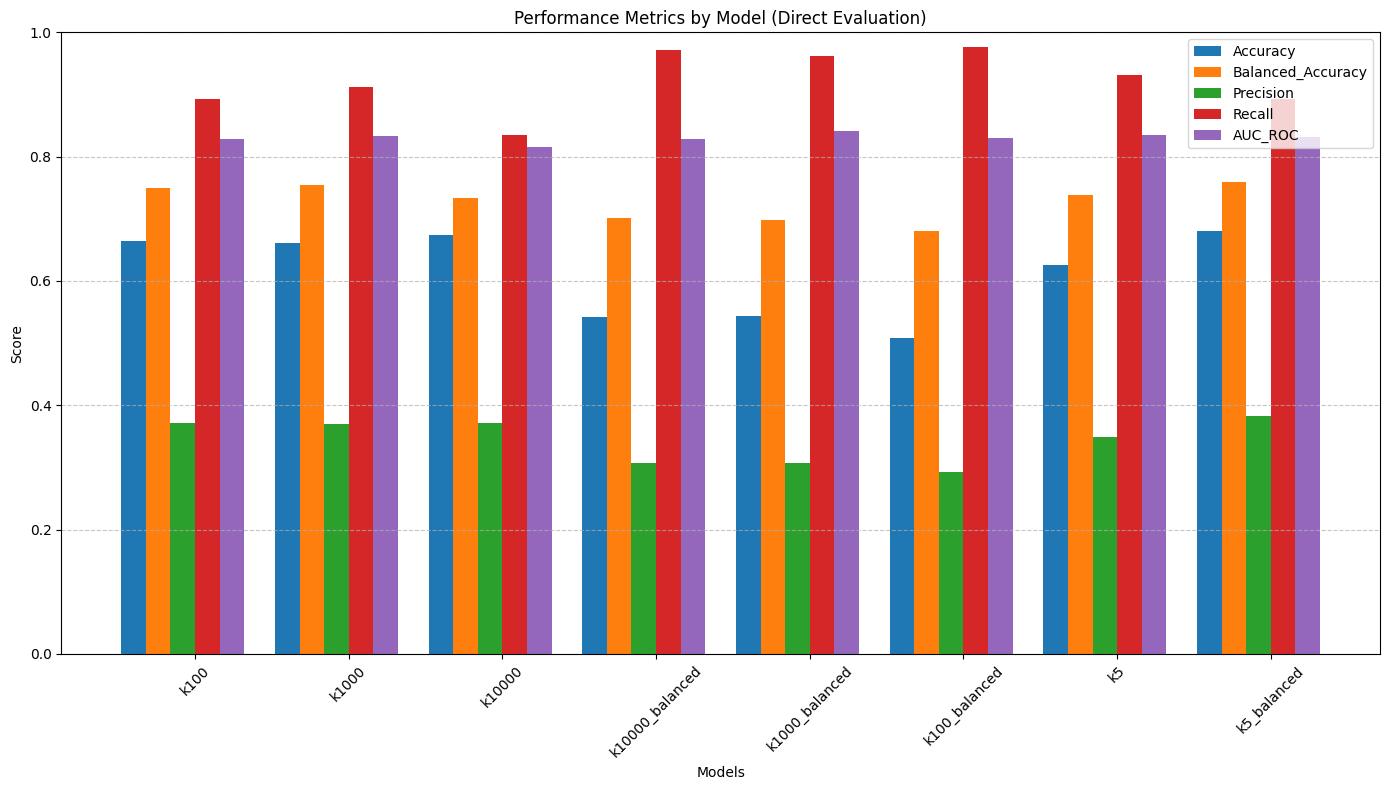

In [23]:
import matplotlib.pyplot as plt

if not metrics_df_direct.empty:
    plt.figure(figsize=(14, 8))
    
    metric_columns = ['Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'AUC_ROC']
    x = np.arange(len(metrics_df_direct['Model']))
    width = 0.16  # Narrower bars to fit all metrics
    
    for i, metric in enumerate(metric_columns):
        plt.bar(x + i*width - 0.32, metrics_df_direct[metric], width, label=metric)
    
    plt.ylabel('Score')
    plt.xlabel('Models')
    plt.title('Performance Metrics by Model (Direct Evaluation)')
    plt.xticks(x + width/2, metrics_df_direct['Model'], rotation=45)
    plt.ylim(0, 1.0)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.savefig('models_knn/model_comparison_metrics_direct.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No metrics data available for plotting.")

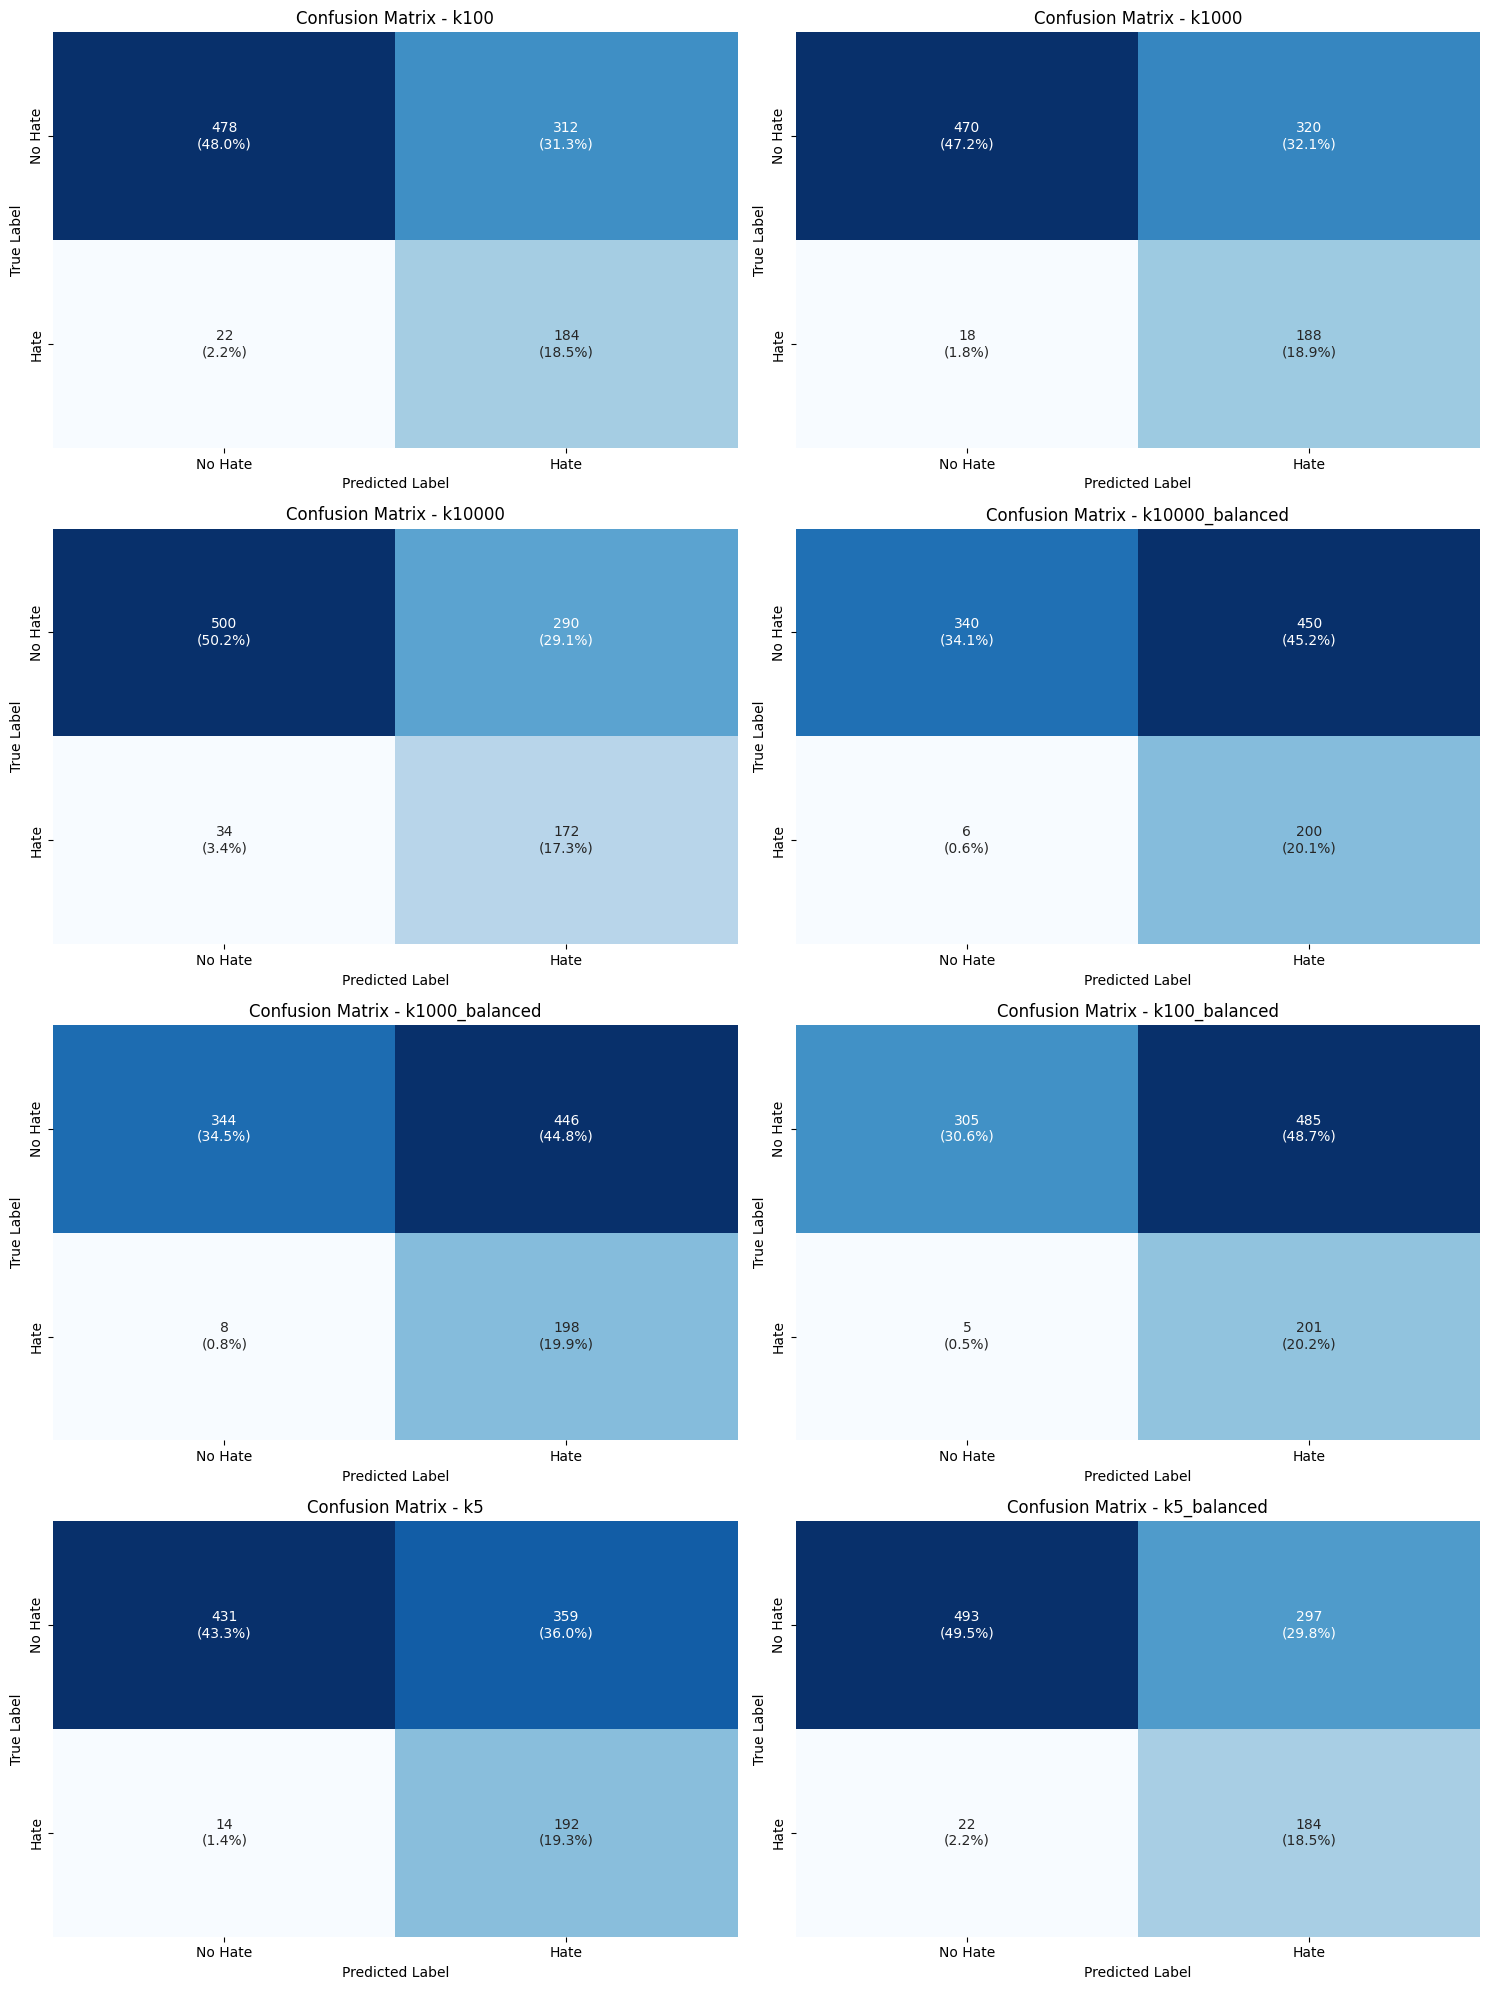

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create confusion matrices for each model using direct evaluation
if not metrics_df_direct.empty:

    num_models = len(metrics_df_direct)
    if num_models <= 2:
        nrows, ncols = 1, num_models
    else:
        nrows = (num_models + 1) // 2  
        ncols = 2
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
    
    # Handle the case of a single subplot
    if num_models == 1:
        axes = np.array([axes])
    elif nrows == 1 and ncols > 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, (dataset_name, eval_result) in enumerate(direct_evaluation_results.items()):
        if eval_result.get('results') is None:
            continue
        
        results = eval_result['results']
        
        # Extract confusion matrix values
        TP = results.get('TP', 0)
        FP = results.get('FP', 0)
        FN = results.get('FN', 0)
        TN = results.get('TN', 0)
        
        # Create confusion matrix
        cm = np.array([[TN, FP], [FN, TP]])
        
        # Calculate total samples for percentage calculation
        total = TN + FP + FN + TP
        
        # Create a string representation with count and percentage
        cm_text = np.array([[f"{TN}\n({TN/total:.1%})", f"{FP}\n({FP/total:.1%})"], 
                           [f"{FN}\n({FN/total:.1%})", f"{TP}\n({TP/total:.1%})"]])
        
        # Plot confusion matrix with custom annotations
        sns.heatmap(cm, annot=cm_text, fmt="", cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {dataset_name}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['No Hate', 'Hate'])
        axes[i].set_yticklabels(['No Hate', 'Hate'])
    
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('models_knn/model_confusion_matrices_direct_with_percent.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No metrics data available for confusion matrices.")